In [38]:
import warnings
warnings.filterwarnings('ignore')

In [92]:
import pandas as pd
import numpy as np
import math
#from skimpy import skim

from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score

from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier


# для нейронки
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
import keras
from tensorflow.keras import layers, callbacks
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
# from tensorflow.keras.optimizers import Adam
from keras.metrics import BinaryAccuracy, AUC

from keras.models import Sequential
#from tensorflow import keras
from keras.layers import Dense, SimpleRNN, Activation, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization, Dropout
from keras import optimizers
from keras.utils import to_categorical

from sklearn.utils.class_weight import compute_class_weight

In [40]:
import matplotlib as mlp

sns.set_theme(style='darkgrid', palette='mako')

mlp.rcParams['axes.labelsize'] = 10
mlp.rcParams['axes.titlesize'] = 15

In [41]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

In [42]:
RANDOM = 42

# LOADING DATA

In [43]:
cargotype_info = pd.read_csv('data/cargotype_info.csv', index_col='Unnamed: 0')
carton_price = pd.read_excel('data/carton_price.xlsx')
carton = pd.read_csv('data/carton.csv')
data = pd.read_csv('data/data.csv', index_col='Unnamed: 0')
sku_cargotypes = pd.read_csv('data/sku_cargotypes.csv', index_col='Unnamed: 0')
sku = pd.read_csv('data/sku.csv', index_col='Unnamed: 0')

In [44]:
sku_cargotypes

,sku,cargotype
0,4862bf0e760a593b13f3f2fcf822e533,290
1,4862bf0e760a593b13f3f2fcf822e533,901
2,50d3c4fc66ad423b7feaadff2d682ee0,290
3,50d3c4fc66ad423b7feaadff2d682ee0,901
4,24ce9dba9f301ada55f60e25ee1498d2,290
...,...,...
21053147,5786e5c2309967c64b10e443ce1a807c,691
21053148,859788a147004b9a1d24a8168460f79a,200
21053149,859788a147004b9a1d24a8168460f79a,290
21053150,859788a147004b9a1d24a8168460f79a,310


In [45]:
# явно отсортированные
not_need_box = [360, 340]

In [46]:
mb_not_important = [690, 691, 692, 931, 930, 350, 920, 292, 291, 290, 303, 302, 110, 752, 751, 410, 799, 20, 400, 0, 780, 760, 510, 150, 790, 950, 990, 985, 301]

carton_price.columns = ['cartontype', 'price']
carton.columns = [s.lower() for s in carton.columns]

In [47]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [48]:
corr_test = pd.merge(sku_cargotypes, data[['sku', 'selected_cartontype']], on='sku', how='left')

In [49]:
corr_test['selected_cartontype'] = label_encoder.fit_transform(corr_test['selected_cartontype'])

In [50]:
corr_test[['cargotype', 'selected_cartontype']].corr() # корреляция категория тип упаковки

,cargotype,selected_cartontype
cargotype,1.000000,0.021945
selected_cartontype,0.021945,1.000000


In [51]:
sku_cargotypes_filtred = pd.merge(data[['sku']].drop_duplicates(), sku_cargotypes, on='sku', how='left') # дропаем тех которых у нас нет
#sku_cargotypes_filtred = sku_cargotypes_filtred.query('cargotype not in @mb_not_important') # дропаем как мне кажется не особо важные
sku_groups = sku_cargotypes_filtred.groupby('sku')['cargotype'].apply(list).reset_index()
#sku_groups = pd.merge(data[['sku']].drop_duplicates(), sku_groups, on='sku', how='left') # 
sku_groups.head()

,sku,cargotype
0,00001dba9dfe01a550c23064c2b8e96f,[nan]
1,000198cfae123aef536f2fcf0b104049,"[290.0, 310.0, 410.0, 720.0, 750.0, 770.0]"
2,0003da69535758c817b78b64da05aae0,"[290.0, 310.0, 340.0, 750.0]"
3,0003fb4df9f32661d8772b1eac96e5ea,"[290.0, 600.0, 610.0, 950.0, 960.0, 970.0, 980.0]"
4,0005b21e4cba70e646f9f8f9a5d88d4e,"[290.0, 440.0, 441.0, 480.0, 490.0, 520.0, 690.0]"


In [52]:
def gen_geometry_feat(df, a, b, c):
    '''
    генерим геометрические фичи
    a, b, c -- размеры
    '''
    df['dim_sum'] = df[[a, b, c]].sum(axis=1)
    df['vol'] = np.floor(df[[a, b, c]].prod(axis=1))
    df['dim_mean'] = np.floor(df[[a, b, c]].mean(axis=1))
    df['dim_median'] = np.floor(df[[a, b, c]].median(axis=1))

    df['prod_a_b'] = np.floor(df[[a, b]].prod(axis=1))
    df['prod_a_c'] = np.floor(df[[a, c]].prod(axis=1))
    df['prod_b_c'] = np.floor(df[[b, c]].prod(axis=1))
    
    df['prod_min'] = df[['prod_a_b', 'prod_a_c', 'prod_b_c']].min(axis=1)
    df['prod_mean'] = np.floor(df[['prod_a_b', 'prod_a_c', 'prod_b_c']].mean(axis=1))

    df['diag'] = round(np.sqrt(df[a]**2 + df[b]**2 + df[c]**2), 1)
    return df

In [53]:
sku = gen_geometry_feat(sku, 'a', 'b', 'c')
carton = gen_geometry_feat(carton, 'length', 'width', 'height')

In [54]:
non_volume = ['KSD', 'NONPACK', 'STRETCH'] # нулевой объем помешает потом

In [55]:
# фичи для упаковок, для сравнения с фичами заказа
new_carton = carton.query('cartontype not in @non_volume').set_index('cartontype').unstack().reset_index()
new_carton = new_carton.rename(
    columns={
        'level_0': 'carton_dim',
        0: 'value'
})

new_carton['carton_type_dim'] = new_carton['carton_dim'] + '_' + new_carton['cartontype']
new_carton = new_carton.drop(['carton_dim', 'cartontype'], axis=1)
new_carton_t =  new_carton.set_index('carton_type_dim').T

In [56]:
df = data.copy()

In [57]:
cols_to_drop = ['who', # Лишняя информация
                'trackingid', # Лишняя информация для обучения
                'recommended_cartontype', # Работа прошлого алгоритма - для обучения лишняя инфа
                'recommended_carton', # Дубликат
                'selected_cartontype', # Дубликат 
                'rec_calc_cube', # Результат предсказания
                #'orderkey', 
                'whs' # Не влияет на задачу
                ]

In [58]:
df = df.drop(cols_to_drop, axis=1)
df.head()

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
3,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
4,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd


In [59]:
# не хватает оперативки

# mlb = MultiLabelBinarizer()
# one_hot = mlb.fit_transform(sku_groups['cargotype'])

# one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)
# one_hot_df['sku'] = sku_groups['sku']
# df = pd.merge(df, one_hot_df, on='sku', how='left')

In [60]:
sku = sku[sku['vol']>0]

In [61]:
df = pd.merge(df, sku, on='sku', how='left')
df = df.rename(columns={'vol':'sku_vol', 
                        'a':'sku_a', 
                        'b': 'sku_b',
                        'c': 'sku_c'})

df.head(3)

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4


In [62]:
df.isna().sum()

orderkey               0
box_num                0
selected_carton        0
sel_calc_cube          0
pack_volume            0
goods_wght             0
sku                    0
sku_a              10899
sku_b              10899
sku_c              10899
dim_sum            10899
sku_vol            10899
dim_mean           10899
dim_median         10899
prod_a_b           10899
prod_a_c           10899
prod_b_c           10899
prod_min           10899
prod_mean          10899
diag               10899
dtype: int64

In [63]:
df = df.dropna()
#df = df.query('goods_wght!=0') # metrics 0.3

In [64]:
df

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
3,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
4,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325618,0e4f34db53e37d6bf171c2e055e2b4e0,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,26.0,20.0,4.0,50.0,2080.0,16.0,20.0,520.0,104.0,80.0,80.0,234.0,33.0
325619,0e4f34db53e37d6bf171c2e055e2b4e0,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,26.0,20.0,4.0,50.0,2080.0,16.0,20.0,520.0,104.0,80.0,80.0,234.0,33.0
325620,e71d2e750ce9a7a39c273c634be1665d,1,YMC,8525,3523,0.284,9db21acf9e6c1a66493c246c1461f989,11.4,10.2,30.3,51.9,3523.0,17.0,11.0,116.0,345.0,309.0,116.0,256.0,33.9
325621,2e2a642f611b5a6f2c404ab945fbc2a3,1,MYB,2816,552,0.230,4aedb72c5662562524f6119918c7179b,23.0,2.0,12.0,37.0,552.0,12.0,12.0,46.0,276.0,24.0,24.0,115.0,26.0


In [65]:
df_sum = df.groupby('orderkey', sort=False).sum() # суммируем по заказам

In [66]:
df_sum

,box_num,sel_calc_cube,pack_volume,goods_wght,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
orderkey,,,,,,,,,,,,,,,,,
d48f3211c1ffccdc374f23139a9ab668,64,0,83886,4.100,451.0,246.0,1271.0,1968.0,83886.0,656.0,451.0,2706.0,13981.0,7626.0,2706.0,8077.0,1369.4
4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,18.6,3.3,49.7,71.6,3050.0,23.0,18.0,61.0,924.0,164.0,61.0,383.0,53.2
3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,30.0,23.0,22.0,75.0,15180.0,25.0,23.0,690.0,660.0,506.0,506.0,618.0,43.7
7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,14.0,10.7,43.8,68.5,6561.0,22.0,14.0,149.0,613.0,468.0,149.0,410.0,47.2
097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,23.4,8.0,33.9,65.3,6346.0,21.0,23.0,187.0,793.0,271.0,187.0,417.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8ed0af8473526c54b4b2f99f0060c3ea,2,0,50336,2.520,88.0,26.0,88.0,202.0,50336.0,66.0,88.0,1144.0,3872.0,1144.0,1144.0,2052.0,127.2
0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,52.0,40.0,8.0,100.0,4160.0,32.0,40.0,1040.0,208.0,160.0,160.0,468.0,66.0
e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,11.4,10.2,30.3,51.9,3523.0,17.0,11.0,116.0,345.0,309.0,116.0,256.0,33.9


In [67]:
# возвращаем потеряный таргет
order_pack = df[['orderkey', 'selected_carton']].drop_duplicates()
df_sum = pd.merge(df_sum, order_pack, on= 'orderkey', how='left')

In [68]:
# добавляем максимальные размеры одного товара
df_grouped = df.groupby('orderkey', sort=False)[['sku_a', 'sku_b', 'sku_c', 'goods_wght']].max().reset_index() 
df_grouped['sku_max_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].sum(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
df_grouped['sku_mean_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].mean(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
df_grouped['sku_prod_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].prod(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
# ratio max к остальным
df_grouped['sku_ratio_max_a'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_a']), 1)
df_grouped['sku_ratio_max_b'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_b']), 1)
df_grouped['sku_ratio_max_c'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_c']), 1)
# weight
df_grouped['dens'] = round(np.divide(df_grouped['goods_wght']*10**4, df_grouped['sku_prod_size']), 1)
df_grouped['wght_max_len'] = round(np.divide(df_grouped['goods_wght']*10**3, df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)), 1)

df_grouped['sku_max_diag'] = round(np.sqrt(df_grouped['sku_a']**2 + df_grouped['sku_b']**2 + df_grouped['sku_c']**2), 1)
df_grouped['sku_max_diag'] = round(np.sqrt(df['sku_a']**2 + df['sku_b']**2 + df['sku_c']**2), 1)

df_sum = pd.merge(df_sum, df_grouped[['orderkey', 'sku_max_size', 'sku_mean_size', 
                                  'sku_prod_size', 'sku_ratio_max_a', 'sku_ratio_max_b', 
                                  'sku_ratio_max_c', 'dens', 'wght_max_len', 'sku_max_diag']], on='orderkey', how='left')

In [69]:
df_sum

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,selected_carton,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag
0,d48f3211c1ffccdc374f23139a9ab668,64,0,83886,4.100,451.0,246.0,1271.0,1968.0,83886.0,656.0,451.0,2706.0,13981.0,7626.0,2706.0,8077.0,1369.4,NONPACK,48.0,16.000000,2046.000,2.8,5.2,1.0,0.5,3.2,33.4
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,18.6,3.3,49.7,71.6,3050.0,23.0,18.0,61.0,924.0,164.0,61.0,383.0,53.2,STRETCH,71.6,23.866667,3050.586,2.7,15.1,1.0,2.9,18.0,33.4
2,3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,30.0,23.0,22.0,75.0,15180.0,25.0,23.0,690.0,660.0,506.0,506.0,618.0,43.7,STRETCH,75.0,25.000000,15180.000,1.0,1.3,1.4,2.9,146.7,33.4
3,7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,14.0,10.7,43.8,68.5,6561.0,22.0,14.0,149.0,613.0,468.0,149.0,410.0,47.2,STRETCH,68.5,22.833333,6561.240,3.1,4.1,1.0,1.1,16.0,33.4
4,097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,23.4,8.0,33.9,65.3,6346.0,21.0,23.0,187.0,793.0,271.0,187.0,417.0,42.0,STRETCH,65.3,21.766667,6346.080,1.4,4.2,1.0,3.3,61.3,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155344,8ed0af8473526c54b4b2f99f0060c3ea,2,0,50336,2.520,88.0,26.0,88.0,202.0,50336.0,66.0,88.0,1144.0,3872.0,1144.0,1144.0,2052.0,127.2,NONPACK,101.0,33.666667,25168.000,1.0,3.4,1.0,0.5,28.6,24.6
155345,0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,52.0,40.0,8.0,100.0,4160.0,32.0,40.0,1040.0,208.0,160.0,160.0,468.0,66.0,MYC,50.0,16.666667,2080.000,1.0,1.3,6.5,0.5,3.8,10.2
155346,e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,11.4,10.2,30.3,51.9,3523.0,17.0,11.0,116.0,345.0,309.0,116.0,256.0,33.9,YMC,51.9,17.300000,3523.284,2.7,3.0,1.0,0.8,9.4,23.6
155347,2e2a642f611b5a6f2c404ab945fbc2a3,1,2816,552,0.230,23.0,2.0,12.0,37.0,552.0,12.0,12.0,46.0,276.0,24.0,24.0,115.0,26.0,MYB,37.0,12.333333,552.000,1.0,11.5,1.9,4.2,10.0,23.5


In [70]:
# df = df_sum.dropna().reset_index(drop=True)
#df = df[df['selected_carton']!='YMB']
# df[df['selected_carton'] =='YMB']

In [71]:
# создаем столбцы с размерами коробок пока объем и диагонали(feature_importance считает что они важны)
df_sum[new_carton_t.filter(like='vol').columns.tolist()] = new_carton_t[new_carton_t.filter(like='vol').columns.tolist()].values.reshape(-1,1).flatten().tolist()
df_sum[new_carton_t.filter(like='diag').columns.tolist()] = new_carton_t[new_carton_t.filter(like='diag').columns.tolist()].values.reshape(-1,1).flatten().tolist()

In [72]:
df_sum.head(3)

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,selected_carton,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag,vol_YMA,vol_YMC,vol_YME,vol_YMF,vol_YMG,vol_YMH,vol_YMJ,vol_YML,vol_YMN,vol_YMO,vol_YMP,vol_YMQ,vol_YMR,vol_YMS,vol_YMU,vol_YMV,vol_YMW,vol_YMХ,vol_MYF,vol_YMX,vol_YMY,vol_MYA,vol_MYB,vol_MYC,vol_MYD,vol_MYE,diag_YMA,diag_YMC,diag_YME,diag_YMF,diag_YMG,diag_YMH,diag_YMJ,diag_YML,diag_YMN,diag_YMO,diag_YMP,diag_YMQ,diag_YMR,diag_YMS,diag_YMU,diag_YMV,diag_YMW,diag_YMХ,diag_MYF,diag_YMX,diag_YMY,diag_MYA,diag_MYB,diag_MYC,diag_MYD,diag_MYE
0,d48f3211c1ffccdc374f23139a9ab668,64,0,83886,4.100,451.0,246.0,1271.0,1968.0,83886.0,656.0,451.0,2706.0,13981.0,7626.0,2706.0,8077.0,1369.4,NONPACK,48.0,16.000000,2046.000,2.8,5.2,1.0,0.5,3.2,33.4,3705.0,9000.0,40050.0,13125.0,26820.0,72240.0,69600.0,108000.0,144000.0,58500.0,46200.0,168000.0,384000.0,263599.0,2592.0,4292.0,18000.0,46800.0,1500.0,46800.0,72800.0,999.0,3449.0,8436.0,15579.0,26277.0,30.6,39.1,61.5,45.6,57.4,97.8,75.1,85.0,93.8,81.5,79.3,100.5,128.1,118.3,36.3,47.2,52.2,78.4,25.5,78.4,89.5,25.2,39.1,49.0,63.3,76.9
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,18.6,3.3,49.7,71.6,3050.0,23.0,18.0,61.0,924.0,164.0,61.0,383.0,53.2,STRETCH,71.6,23.866667,3050.586,2.7,15.1,1.0,2.9,18.0,33.4,3705.0,9000.0,40050.0,13125.0,26820.0,72240.0,69600.0,108000.0,144000.0,58500.0,46200.0,168000.0,384000.0,263599.0,2592.0,4292.0,18000.0,46800.0,1500.0,46800.0,72800.0,999.0,3449.0,8436.0,15579.0,26277.0,30.6,39.1,61.5,45.6,57.4,97.8,75.1,85.0,93.8,81.5,79.3,100.5,128.1,118.3,36.3,47.2,52.2,78.4,25.5,78.4,89.5,25.2,39.1,49.0,63.3,76.9
2,3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,30.0,23.0,22.0,75.0,15180.0,25.0,23.0,690.0,660.0,506.0,506.0,618.0,43.7,STRETCH,75.0,25.000000,15180.000,1.0,1.3,1.4,2.9,146.7,33.4,3705.0,9000.0,40050.0,13125.0,26820.0,72240.0,69600.0,108000.0,144000.0,58500.0,46200.0,168000.0,384000.0,263599.0,2592.0,4292.0,18000.0,46800.0,1500.0,46800.0,72800.0,999.0,3449.0,8436.0,15579.0,26277.0,30.6,39.1,61.5,45.6,57.4,97.8,75.1,85.0,93.8,81.5,79.3,100.5,128.1,118.3,36.3,47.2,52.2,78.4,25.5,78.4,89.5,25.2,39.1,49.0,63.3,76.9


In [73]:
# hard code
def diff(row):
    '''
    отношение диагонали к каждой из диагоналей всех коробок
    '''
    return row['diag'] / row[new_carton_t.filter(like='diag').columns.tolist()]


df_sum[new_carton_t.filter(like='diag').columns.tolist()] = df_sum.apply(diff, axis=1)

In [74]:
def diff(row):
    '''
    отношение объема к каждой из диагоналей всех коробок
    '''
    return row['sku_vol'] / row[new_carton_t.filter(like='vol').columns.tolist()]


df_sum[new_carton_t.filter(like='vol').columns.tolist()] = df_sum.apply(diff, axis=1)

In [75]:
df = df.drop('orderkey', axis=1)

In [76]:
df

,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
1,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
2,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
3,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
4,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325618,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,26.0,20.0,4.0,50.0,2080.0,16.0,20.0,520.0,104.0,80.0,80.0,234.0,33.0
325619,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,26.0,20.0,4.0,50.0,2080.0,16.0,20.0,520.0,104.0,80.0,80.0,234.0,33.0
325620,1,YMC,8525,3523,0.284,9db21acf9e6c1a66493c246c1461f989,11.4,10.2,30.3,51.9,3523.0,17.0,11.0,116.0,345.0,309.0,116.0,256.0,33.9
325621,1,MYB,2816,552,0.230,4aedb72c5662562524f6119918c7179b,23.0,2.0,12.0,37.0,552.0,12.0,12.0,46.0,276.0,24.0,24.0,115.0,26.0


<Axes: >

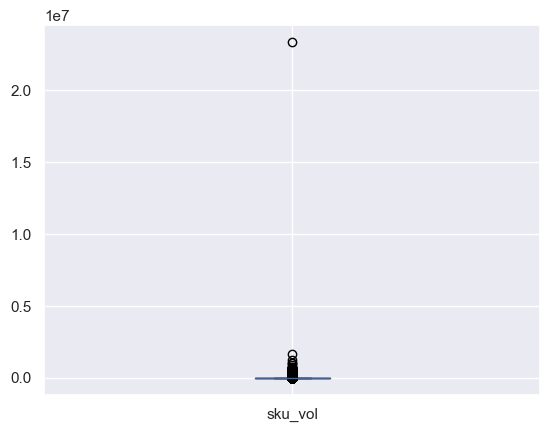

In [77]:
df_sum['sku_vol'].plot(kind='box')

In [78]:
# дроп выбросов по объему
q1 = df_sum['sku_vol'].quantile(0.25)
q3 = df_sum['sku_vol'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_no_outlier_vol = df_sum[(df_sum['sku_vol'] >= lower_bound) & (df_sum['sku_vol'] <= upper_bound)]

<Axes: >

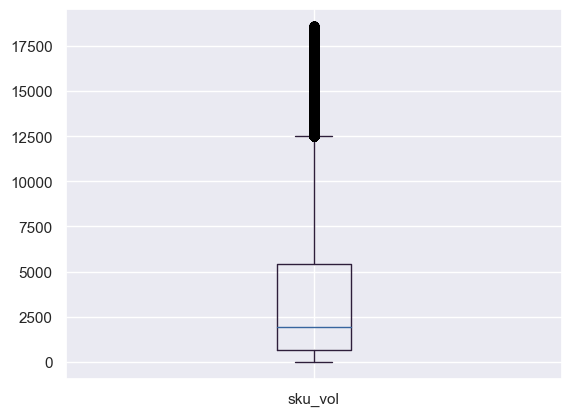

In [79]:
df_no_outlier_vol['sku_vol'].plot(kind='box')

In [80]:
# для категорий товаров
# df.describe()
# cols_zero_max = df.describe().columns[df.describe().loc['max'] == 0]
# cols_zero_max
# df = df.drop(cols_zero_max, axis=1)

In [81]:
df_no_outlier_vol

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,selected_carton,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag,vol_YMA,vol_YMC,vol_YME,vol_YMF,vol_YMG,vol_YMH,vol_YMJ,vol_YML,vol_YMN,vol_YMO,vol_YMP,vol_YMQ,vol_YMR,vol_YMS,vol_YMU,vol_YMV,vol_YMW,vol_YMХ,vol_MYF,vol_YMX,vol_YMY,vol_MYA,vol_MYB,vol_MYC,vol_MYD,vol_MYE,diag_YMA,diag_YMC,diag_YME,diag_YMF,diag_YMG,diag_YMH,diag_YMJ,diag_YML,diag_YMN,diag_YMO,diag_YMP,diag_YMQ,diag_YMR,diag_YMS,diag_YMU,diag_YMV,diag_YMW,diag_YMХ,diag_MYF,diag_YMX,diag_YMY,diag_MYA,diag_MYB,diag_MYC,diag_MYD,diag_MYE
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,18.6,3.3,49.7,71.6,3050.0,23.0,18.0,61.0,924.0,164.0,61.0,383.0,53.2,STRETCH,71.6,23.866667,3050.586,2.7,15.1,1.0,2.9,18.0,33.4,0.823212,0.338889,0.076155,0.232381,0.113721,0.042220,0.043822,0.028241,0.021181,0.052137,0.066017,0.018155,0.007943,0.011571,1.176698,0.710624,0.169444,0.065171,2.033333,0.065171,0.041896,3.053053,0.884314,0.361546,0.195776,0.116071,1.738562,1.360614,0.865041,1.166667,0.926829,0.543967,0.708389,0.625882,0.567164,0.652761,0.670870,0.529353,0.415301,0.449704,1.465565,1.127119,1.019157,0.678571,2.086275,0.678571,0.594413,2.111111,1.360614,1.085714,0.840442,0.691808
2,3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,30.0,23.0,22.0,75.0,15180.0,25.0,23.0,690.0,660.0,506.0,506.0,618.0,43.7,STRETCH,75.0,25.000000,15180.000,1.0,1.3,1.4,2.9,146.7,33.4,4.097166,1.686667,0.379026,1.156571,0.565996,0.210133,0.218103,0.140556,0.105417,0.259487,0.328571,0.090357,0.039531,0.057587,5.856481,3.536813,0.843333,0.324359,10.120000,0.324359,0.208516,15.195195,4.401276,1.799431,0.974389,0.577692,1.428105,1.117647,0.710569,0.958333,0.761324,0.446830,0.581891,0.514118,0.465885,0.536196,0.551072,0.434826,0.341140,0.369400,1.203857,0.925847,0.837165,0.557398,1.713725,0.557398,0.488268,1.734127,1.117647,0.891837,0.690363,0.568270
3,7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,14.0,10.7,43.8,68.5,6561.0,22.0,14.0,149.0,613.0,468.0,149.0,410.0,47.2,STRETCH,68.5,22.833333,6561.240,3.1,4.1,1.0,1.1,16.0,33.4,1.770850,0.729000,0.163820,0.499886,0.244631,0.090822,0.094267,0.060750,0.045562,0.112154,0.142013,0.039054,0.017086,0.024890,2.531250,1.528658,0.364500,0.140192,4.374000,0.140192,0.090124,6.567568,1.902291,0.777738,0.421144,0.249686,1.542484,1.207161,0.767480,1.035088,0.822300,0.482618,0.628495,0.555294,0.503198,0.579141,0.595208,0.469652,0.368462,0.398986,1.300275,1.000000,0.904215,0.602041,1.850980,0.602041,0.527374,1.873016,1.207161,0.963265,0.745656,0.613784
4,097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,23.4,8.0,33.9,65.3,6346.0,21.0,23.0,187.0,793.0,271.0,187.0,417.0,42.0,STRETCH,65.3,21.766667,6346.080,1.4,4.2,1.0,3.3,61.3,33.4,1.712821,0.705111,0.158452,0.483505,0.236614,0.087846,0.091178,0.058759,0.044069,0.108479,0.137359,0.037774,0.016526,0.024074,2.448302,1.478565,0.352556,0.135598,4.230667,0.135598,0.087170,6.352352,1.839954,0.752252,0.407343,0.241504,1.372549,1.074169,0.682927,0.921053,0.731707,0.429448,0.559254,0.494118,0.447761,0.515337,0.529634,0.417910,0.327869,0.355030,1.157025,0.889831,0.804598,0.535714,1.647059,0.535714,0.469274,1.666667,1.074169,0.857143,0.663507,0.546164
6,abea12f00a205457b289b2e5c0351e17,1,0,7569,6.080,29.0,9.0,29.0,67.0,7569.0,22.0,29.0,261.0,841.0,261.0,261.0,454.0,42.0,NONPACK,67.0,22.333333,7569.000,1.0,3.2,1.0,8.0,209.7,33.4,2.042915,0.841000,0.188989,0.576686,0.282215,0.104776,0.108750,0.070083,0.052562,0.129385,0.163831,0.045054,0.019711,0.028714,2.920139,1.763514,0.420500,0.161731,5.046000,0.161731,0.103970,7.576577,2.194549,0.897226,0.485846,0.288047,1.372549,1.074169,0.682927,0.921053,0.731707,0.429448,0.559254,0.494118,0.447761,0.515337,0.529634,0.417910,0.327869,0.355030,1.157025,0.889831,0.804598,0.535714,1.647059,0.535714,0.469274,1.666667,1.074169,0.857143,0.663507,0.546164
...,...,...,...,...

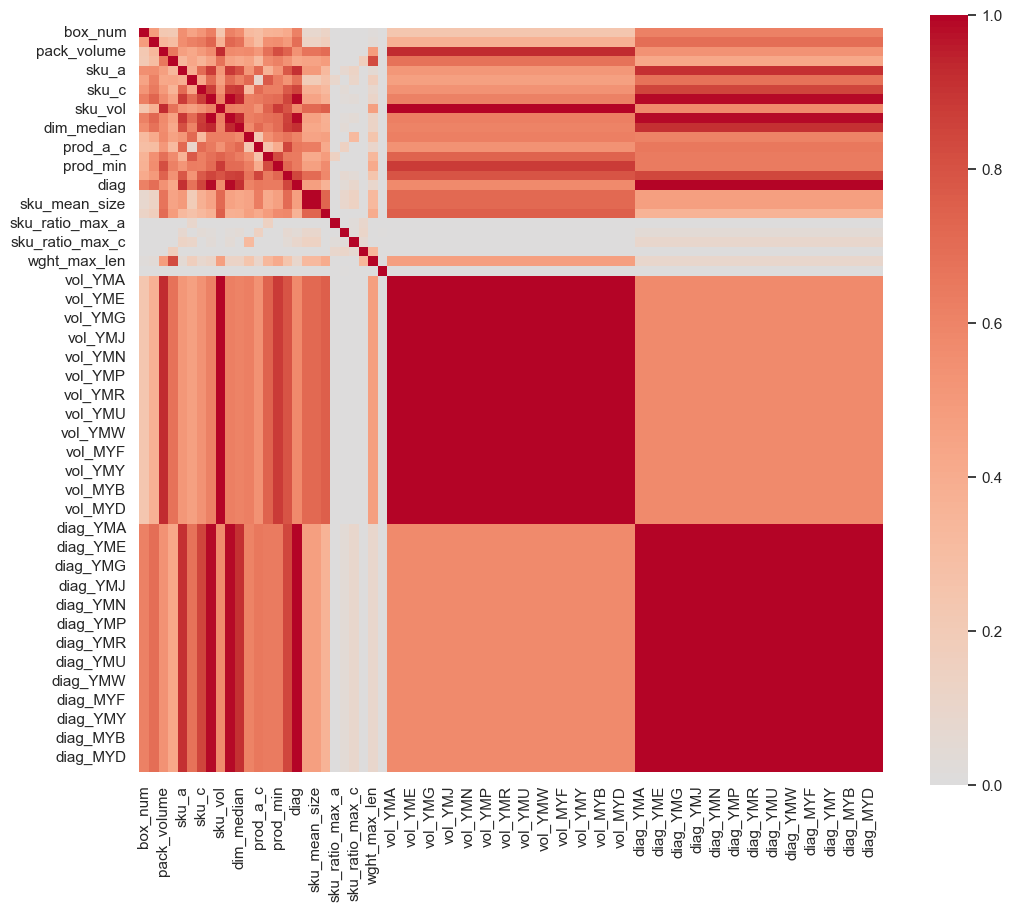

In [88]:
numeric_columns = df_no_outlier_vol.loc[:,df_no_outlier_vol.dtypes!=np.object_].columns

plt.figure(figsize=(12, 10))
sns.heatmap(df_no_outlier_vol[numeric_columns].corr(), 
            #annot=True, 
            vmin=0, 
            vmax=1, 
            center=0, 
            cmap='coolwarm', 
            square=True);

In [89]:
corr_feat = set()
corr_matrix = df_no_outlier_vol.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            colname = corr_matrix.columns[i]
            corr_feat.add(colname)       
corr_feat

{'diag',
 'diag_MYA',
 'diag_MYB',
 'diag_MYC',
 'diag_MYD',
 'diag_MYE',
 'diag_MYF',
 'diag_YMA',
 'diag_YMC',
 'diag_YME',
 'diag_YMF',
 'diag_YMG',
 'diag_YMH',
 'diag_YMJ',
 'diag_YML',
 'diag_YMN',
 'diag_YMO',
 'diag_YMP',
 'diag_YMQ',
 'diag_YMR',
 'diag_YMS',
 'diag_YMU',
 'diag_YMV',
 'diag_YMW',
 'diag_YMX',
 'diag_YMY',
 'diag_YMХ',
 'dim_mean',
 'dim_median',
 'dim_sum',
 'prod_mean',
 'prod_min',
 'sku_mean_size',
 'sku_vol',
 'vol_MYA',
 'vol_MYB',
 'vol_MYC',
 'vol_MYD',
 'vol_MYE',
 'vol_MYF',
 'vol_YMA',
 'vol_YMC',
 'vol_YME',
 'vol_YMF',
 'vol_YMG',
 'vol_YMH',
 'vol_YMJ',
 'vol_YML',
 'vol_YMN',
 'vol_YMO',
 'vol_YMP',
 'vol_YMQ',
 'vol_YMR',
 'vol_YMS',
 'vol_YMU',
 'vol_YMV',
 'vol_YMW',
 'vol_YMX',
 'vol_YMY',
 'vol_YMХ'}

In [84]:
# Проверить
#df_no_outlier_vol = df_no_outlier_vol.drop(corr_feat, axis=1)

In [85]:
# fltr_nonpack =  ["STRETCH", "NONPACK"] # 
# df_no_outlier_vol_nonpack = df_no_outlier_vol.query('selected_carton not in @fltr_nonpack')
# df_no_outlier_vol_nonpack

# Модель

In [97]:
df_no_outlier_vol = df_no_outlier_vol.query('selected_carton != "YMB"')

In [98]:
df_no_outlier_vol['selected_carton'].value_counts()

MYB        39508
MYC        29030
MYA        14361
MYD        12776
YMC         7919
NONPACK     7823
YMA         6730
STRETCH     5321
YMF         4036
MYE         3960
YMW         3407
YMG         2560
MYF          790
YME          322
YMX           29
YML            7
Name: selected_carton, dtype: int64

In [99]:
X = df_no_outlier_vol.drop(['sel_calc_cube', 'box_num', 'pack_volume', 'selected_carton', 'orderkey'], axis=1)
X.columns = X.columns.astype(str)
y = df_no_outlier_vol['selected_carton']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=RANDOM,
                                                    shuffle=True,
                                                    stratify=df_no_outlier_vol['selected_carton']
                                                    )

In [106]:
X_train

,goods_wght,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag,vol_YMA,vol_YMC,vol_YME,vol_YMF,vol_YMG,vol_YMH,vol_YMJ,vol_YML,vol_YMN,vol_YMO,vol_YMP,vol_YMQ,vol_YMR,vol_YMS,vol_YMU,vol_YMV,vol_YMW,vol_YMХ,vol_MYF,vol_YMX,vol_YMY,vol_MYA,vol_MYB,vol_MYC,vol_MYD,vol_MYE,diag_YMA,diag_YMC,diag_YME,diag_YMF,diag_YMG,diag_YMH,diag_YMJ,diag_YML,diag_YMN,diag_YMO,diag_YMP,diag_YMQ,diag_YMR,diag_YMS,diag_YMU,diag_YMV,diag_YMW,diag_YMХ,diag_MYF,diag_YMX,diag_YMY,diag_MYA,diag_MYB,diag_MYC,diag_MYD,diag_MYE
9958,0.050,16.0,1.0,11.0,28.0,176.0,9.0,11.0,16.0,176.0,11.0,11.0,67.0,19.4,28.0,9.333333,176.000,1.0,16.0,1.5,2.8,3.1,34.5,0.047503,0.019556,0.004395,0.013410,0.006562,0.002436,0.002529,0.001630,0.001222,0.003009,0.003810,0.001048,0.000458,0.000668,0.067901,0.041007,0.009778,0.003761,0.117333,0.003761,0.002418,0.176176,0.051029,0.020863,0.011297,0.006698,0.633987,0.496164,0.315447,0.425439,0.337979,0.198364,0.258322,0.228235,0.206823,0.238037,0.244641,0.193035,0.151444,0.163990,0.534435,0.411017,0.371648,0.247449,0.760784,0.247449,0.216760,0.769841,0.496164,0.395918,0.306477,0.252276
51013,0.058,17.2,24.9,4.3,46.4,1841.0,15.0,17.0,428.0,73.0,107.0,73.0,202.0,30.6,46.4,15.466667,1841.604,1.4,1.0,5.8,0.3,2.3,22.8,0.496896,0.204556,0.045968,0.140267,0.068643,0.025484,0.026451,0.017046,0.012785,0.031470,0.039848,0.010958,0.004794,0.006984,0.710262,0.428938,0.102278,0.039338,1.227333,0.039338,0.025288,1.842843,0.533778,0.218231,0.118172,0.070061,1.000000,0.782609,0.497561,0.671053,0.533101,0.312883,0.407457,0.360000,0.326226,0.375460,0.385876,0.304478,0.238876,0.258664,0.842975,0.648305,0.586207,0.390306,1.200000,0.390306,0.341899,1.214286,0.782609,0.624490,0.483412,0.397919
27495,1.769,49.6,16.0,50.3,115.9,10162.0,38.0,47.0,337.0,1607.0,353.0,323.0,765.0,73.9,86.9,28.966667,14770.800,1.0,4.0,1.1,1.0,37.1,14.6,2.742780,1.129111,0.253733,0.774248,0.378896,0.140670,0.146006,0.094093,0.070569,0.173709,0.219957,0.060488,0.026464,0.038551,3.920525,2.367661,0.564556,0.217137,6.774667,0.217137,0.139588,10.172172,2.946361,1.204599,0.652288,0.386726,2.415033,1.890026,1.201626,1.620614,1.287456,0.755624,0.984021,0.869412,0.787846,0.906748,0.931904,0.735323,0.576893,0.624683,2.035813,1.565678,1.415709,0.942602,2.898039,0.942602,0.825698,2.932540,1.890026,1.508163,1.167457,0.960988
75809,3.456,33.8,39.0,22.6,95.4,7446.0,30.0,32.0,658.0,380.0,440.0,380.0,492.0,56.4,47.7,15.900000,3723.915,1.2,1.0,1.7,4.6,88.6,32.6,2.009717,0.827333,0.185918,0.567314,0.277629,0.103073,0.106983,0.068944,0.051708,0.127282,0.161169,0.044321,0.019391,0.028247,2.872685,1.734856,0.413667,0.159103,4.964000,0.159103,0.102280,7.453453,2.158887,0.882646,0.477951,0.283366,1.843137,1.442455,0.917073,1.236842,0.982578,0.576687,0.750999,0.663529,0.601279,0.692025,0.711223,0.561194,0.440281,0.476754,1.553719,1.194915,1.080460,0.719388,2.211765,0.719388,0.630168,2.238095,1.442455,1.151020,0.890995,0.733420
142292,0.400,15.0,5.0,5.0,25.0,375.0,8.0,5.0,75.0,75.0,25.0,25.0,58.0,16.6,25.0,8.333333,375.000,1.0,3.0,3.0,10.7,26.7,19.8,0.101215,0.041667,0.009363,0.028571,0.013982,0.005191,0.005388,0.003472,0.002604,0.006410,0.008117,0.002232,0.000977,0.001423,0.144676,0.087372,0.020833,0.008013,0.250000,0.008013,0.005151,0.375375,0.108727,0.044452,0.024071,0.014271,0.542484,0.424552,0.269919,0.364035,0.289199,0.169734,0.221039,0.195294,0.176972,0.203681,0.209332,0.165174,0.129586,0.140321,0.457300,0.351695,0.318008,0.211735,0.650980,0.211735,0.185475,0.658730,0.424552,0.338776,0.262243,0.215865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145996,0.420,36.0,2.0,26.0

In [107]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [109]:
tree_pipe = Pipeline([
    #('scaler', StandardScaler()),
    #('scaler', RobustScaler()),
    #('pca', PCA(n_components=16)),
    #('tree', KNeighborsClassifier(n_neighbors=8, p=1)),

    
    ('tree', CatBoostClassifier(
        random_state=42,
        early_stopping_rounds=100,
        #learning_rate=0.01, 
        leaf_estimation_method='Gradient',
        iterations=100,
        subsample=0.02,
        #max_depth=4,
        verbose=10,
        #l2_leaf_reg = 7,
        bootstrap_type="Bernoulli",
        #class_weights=class_weights,
        loss_function='MultiClass',
        eval_metric='TotalF1'
        ))
])

tree_pipe.fit(X_train, y_train)

0:	learn: 0.3072689	total: 789ms	remaining: 1m 18s
10:	learn: 0.3413787	total: 6.23s	remaining: 50.4s
20:	learn: 0.3405183	total: 11.6s	remaining: 43.6s
30:	learn: 0.3444943	total: 17s	remaining: 37.9s
40:	learn: 0.3647867	total: 22.6s	remaining: 32.5s
50:	learn: 0.3846381	total: 27.8s	remaining: 26.7s
60:	learn: 0.3945451	total: 33.1s	remaining: 21.2s
70:	learn: 0.4011444	total: 38.4s	remaining: 15.7s
80:	learn: 0.4054067	total: 44.1s	remaining: 10.3s
90:	learn: 0.4098009	total: 49.4s	remaining: 4.89s
99:	learn: 0.4115811	total: 55.2s	remaining: 0us


Pipeline(steps=[('tree',
                 <catboost.core.CatBoostClassifier object at 0x0000024D7FF11060>)])

Text(0.5, 1.0, 'Feature Importance')

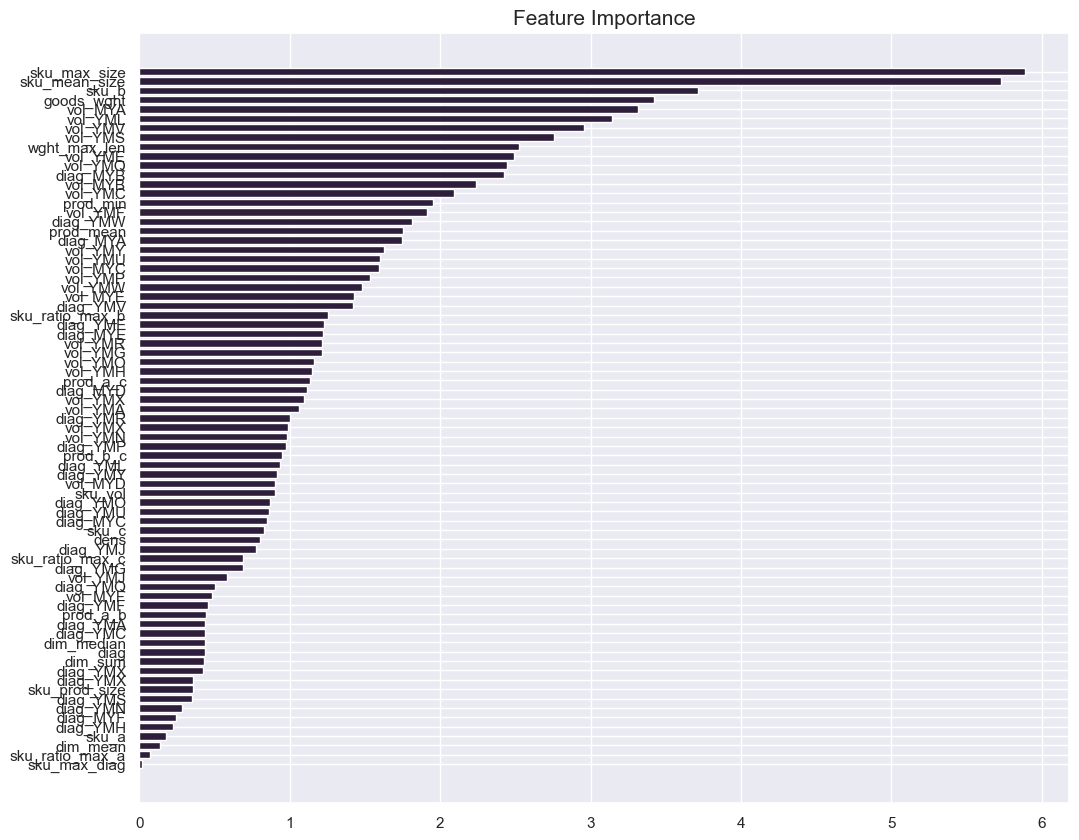

In [110]:
feature_importance = tree_pipe.named_steps['tree'].get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [111]:
tree_preds = tree_pipe.predict(X_test)
tree_pred_proba = tree_pipe.predict_proba(X_test)

print(f'TRAIN ACC: {accuracy_score(y_train, tree_pipe.predict(X_train))}')
print(f'TEST ACC: {accuracy_score(y_test, tree_preds)}')
print(f'TEST F1: {f1_score(y_test, tree_preds, average="weighted")}')

TRAIN ACC: 0.4517770893066754
TEST ACC: 0.45057006783085585
TEST F1: 0.40999063127812063


In [112]:
print(classification_report(y_test, tree_preds))

              precision    recall  f1-score   support

         MYA       0.57      0.29      0.38      3590
         MYB       0.56      0.73      0.63      9877
         MYC       0.43      0.54      0.48      7258
         MYD       0.28      0.38      0.32      3194
         MYE       0.00      0.00      0.00       990
         MYF       0.00      0.00      0.00       197
     NONPACK       0.37      0.57      0.45      1956
     STRETCH       0.33      0.00      0.00      1330
         YMA       0.00      0.00      0.00      1683
         YMC       0.37      0.25      0.30      1980
         YME       0.00      0.00      0.00        80
         YMF       0.32      0.10      0.15      1009
         YMG       0.49      0.23      0.31       640
         YML       0.00      0.00      0.00         2
         YMW       0.25      0.40      0.31       852
         YMX       0.00      0.00      0.00         7

    accuracy                           0.45     34645
   macro avg       0.25   

In [115]:
y_proba = tree_pipe.predict_proba(X_test[100:110])

# два наиболее вероятных класса с вероятностями
top_two = y_proba.argsort()[:, -2:]
top_two_proba = np.round(np.sort(y_proba, axis=1)[:, -2:], 2)

# результаты предсказания
for i in range(len(X_test[100:110])):
    class_names = tree_pipe.classes_[top_two[i]]
    print(f"Для заказа № {i} рекомендуется упаковка: {class_names[0]}, с вероятностью: {top_two_proba[i][0]} или {class_names[1]}, с вероятностью: {top_two_proba[i][1]}, тест {y_test.iloc[i]}")

Для заказа № 0 рекомендуется упаковка: YMG, с вероятностью: 0.16 или YMW, с вероятностью: 0.16, тест MYC
Для заказа № 1 рекомендуется упаковка: MYB, с вероятностью: 0.2 или MYC, с вероятностью: 0.33, тест MYA
Для заказа № 2 рекомендуется упаковка: MYB, с вероятностью: 0.29 или MYC, с вероятностью: 0.39, тест MYD
Для заказа № 3 рекомендуется упаковка: MYA, с вероятностью: 0.35 или MYB, с вероятностью: 0.43, тест YMW
Для заказа № 4 рекомендуется упаковка: YMG, с вероятностью: 0.13 или YMW, с вероятностью: 0.15, тест MYC
Для заказа № 5 рекомендуется упаковка: MYA, с вероятностью: 0.11 или MYB, с вероятностью: 0.57, тест MYB
Для заказа № 6 рекомендуется упаковка: MYD, с вероятностью: 0.2 или MYC, с вероятностью: 0.24, тест MYB
Для заказа № 7 рекомендуется упаковка: MYD, с вероятностью: 0.17 или NONPACK, с вероятностью: 0.19, тест MYB
Для заказа № 8 рекомендуется упаковка: MYC, с вероятностью: 0.18 или MYB, с вероятностью: 0.53, тест MYC
Для заказа № 9 рекомендуется упаковка: MYC, с вероятн